In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import math
from __future__ import division
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

In [ ]:
train_file_path = "../content/drive/MyDrive/Colab Notebooks/coll_u.csv"
dataset_df = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (237362, 97)


In [ ]:
dataset_df.head(3)

,YEAR,CLP,COLL_ID,BUILDING_NAME,PROJECT_ID,PROJECT_NAME,PROVINCE_NAME,DISTICT_NAME,SUBDISTICT_NAME,INTERIOR_SPACE,...,CONVENIENCE_STORE_3KM_SHORTEST,DISCOUNT_STORE_3KM_SHORTEST,DEPARTMENT_STORE_3KM_SHORTEST,GAS_STATION_3KM_SHORTEST,MASS_TRANSIT_3KM_SHORTEST,EDUCATION_3KM_SHORTEST,BANK_3KM_SHORTEST,COFFEE_SHOP_3KM_SHORTEST,PHARMACY_3KM_SHORTEST,GOVERNMENT_OFFICE_3KM_SHORTEST
0,2008,350000,340,อาคารชุดเคหะชุมชนแหลมฉบัง 3,NaN,NaN,ชลบุรี,บางละมุง,บางละมุง,0,...,0.089,0.875,2.409,0.043,0.681,0.079,0.079,0.073,0.802,0.175
1,2010,350000,541,เคหะชุมชนแหลมฉบัง 2,NaN,NaN,ชลบุรี,บางละมุง,บางละมุง,0,...,0.076,0.261,0.000,0.438,0.539,0.047,0.077,0.064,0.694,0.152
2,2008,350000,222,นิรันดร์ แกรนด์ วิลล์,NaN,NaN,ชลบุรี,บางละมุง,หนองปรือ,0,...,0.332,0.617,1.028,0.649,0.000,0.492,0.477,0.471,0.588,0.554


# Data Cleaning
1. Drop unnecessary data column
2. Removing column with 50% null values


In [ ]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237362 entries, 0 to 237361
Data columns (total 97 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   YEAR                            237362 non-null  int64  
 1   CLP                             237362 non-null  int64  
 2   COLL_ID                         237362 non-null  int64  
 3   BUILDING_NAME                   237361 non-null  object 
 4   PROJECT_ID                      163960 non-null  object 
 5   PROJECT_NAME                    165884 non-null  object 
 6   PROVINCE_NAME                   237362 non-null  object 
 7   DISTICT_NAME                    237361 non-null  object 
 8   SUBDISTICT_NAME                 236828 non-null  object 
 9   INTERIOR_SPACE                  237362 non-null  int64  
 10  FIRE_INSUR_AREA                 237362 non-null  int64  
 11  BUILDING_AREA                   237362 non-null  float64
 12  OUTSIDE_LIVING_S

In [ ]:
df_obj = dataset_df.select_dtypes(include = ['object'])
df_obj.info()
total_null_count = df_obj.isnull().sum().sum()
print("Total null values in df_obj:", total_null_count)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237362 entries, 0 to 237361
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   BUILDING_NAME              237361 non-null  object
 1   PROJECT_ID                 163960 non-null  object
 2   PROJECT_NAME               165884 non-null  object
 3   PROVINCE_NAME              237362 non-null  object
 4   DISTICT_NAME               237361 non-null  object
 5   SUBDISTICT_NAME            236828 non-null  object
 6   STREET                     94753 non-null   object
 7   SOI                        88865 non-null   object
 8   ROAD_SURFACE_DESC          173852 non-null  object
 9   PU_ELECTRIC                237362 non-null  object
 10  PU_WATER                   237362 non-null  object
 11  PU_ROAD_LIGHT              237362 non-null  object
 12  PU_DRAIN                   237362 non-null  object
 13  PU_OTHER                   237362 non-null  

In [ ]:
dataset_df.drop([
        'COLL_ID','BUILDING_NAME','PROJECT_ID','PROJECT_NAME','DISTICT_NAME','SUBDISTICT_NAME','STREET','SOI'
],
             axis=1,
             inplace=True)

In [ ]:
df_new = dataset_df[(dataset_df['PROVINCE_NAME'] == 'กรุงเทพมหานคร') & (dataset_df['NO_OF_FLOOR'] <= 7)]

In [ ]:
df_new.shape

(30506, 89)

In [ ]:
print(df_new['NO_OF_FLOOR'])

33        5
36        5
37        5
47        5
48        5
         ..
237321    5
237325    6
237334    5
237340    4
237359    5
Name: NO_OF_FLOOR, Length: 30506, dtype: int64


In [ ]:
# Check for null values in each column
null_counts = df_new.isnull().sum()

# Sort the null_counts Series in descending order
sorted_null_counts = null_counts.sort_values(ascending=False)

# Display the column names and null counts in descending order
print("Column names and null counts in descending order:")
for column, null_count in sorted_null_counts.items():
    print(f"{column}: {null_count}")

Column names and null counts in descending order:
GOVERNMENT_OFFICE_3KM_SHORTEST: 30506
CONVENIENCE_STORE_1KM_SHORTEST: 30506
GOVERNMENT_OFFICE_1KM_SHORTEST: 30506
PHARMACY_1KM_SHORTEST: 30506
COFFEE_SHOP_1KM_SHORTEST: 30506
BANK_1KM_SHORTEST: 30506
EDUCATION_1KM_SHORTEST: 30506
MASS_TRANSIT_1KM_SHORTEST: 30506
GAS_STATION_1KM_SHORTEST: 30506
DEPARTMENT_STORE_1KM_SHORTEST: 30506
DISCOUNT_STORE_1KM_SHORTEST: 30506
HOSPITAL_1KM_SHORTEST: 30506
CONVENIENCE_STORE_3KM: 30506
GOVERNMENT_OFFICE_1KM: 30506
PHARMACY_1KM: 30506
COFFEE_SHOP_1KM: 30506
BANK_1KM: 30506
EDUCATION_1KM: 30506
MASS_TRANSIT_1KM: 30506
HOSPITAL_1KM: 30506
CONVENIENCE_STORE_1KM: 30506
DISCOUNT_STORE_1KM: 30506
GAS_STATION_1KM: 30506
HOSPITAL_3KM: 30506
DISCOUNT_STORE_3KM: 30506
GOVERNMENT_OFFICE_3KM: 30506
PHARMACY_3KM_SHORTEST: 30506
COFFEE_SHOP_3KM_SHORTEST: 30506
BANK_3KM_SHORTEST: 30506
EDUCATION_3KM_SHORTEST: 30506
MASS_TRANSIT_3KM_SHORTEST: 30506
GAS_STATION_3KM_SHORTEST: 30506
DEPARTMENT_STORE_3KM_SHORTEST: 30506
D

In [ ]:
df_new.drop([
'GOVERNMENT_OFFICE_3KM_SHORTEST',
'CONVENIENCE_STORE_1KM_SHORTEST',
'GOVERNMENT_OFFICE_1KM_SHORTEST',
'PHARMACY_1KM_SHORTEST',
'COFFEE_SHOP_1KM_SHORTEST',
'BANK_1KM_SHORTEST',
'EDUCATION_1KM_SHORTEST',
'MASS_TRANSIT_1KM_SHORTEST',
'GAS_STATION_1KM_SHORTEST',
'DEPARTMENT_STORE_1KM_SHORTEST',
'DISCOUNT_STORE_1KM_SHORTEST',
'HOSPITAL_1KM_SHORTEST',
'CONVENIENCE_STORE_3KM',
'GOVERNMENT_OFFICE_1KM',
'PHARMACY_1KM',
'COFFEE_SHOP_1KM',
'BANK_1KM',
'EDUCATION_1KM',
'MASS_TRANSIT_1KM',
'HOSPITAL_1KM',
'CONVENIENCE_STORE_1KM',
'DISCOUNT_STORE_1KM',
'GAS_STATION_1KM',
'HOSPITAL_3KM',
'DISCOUNT_STORE_3KM',
'GOVERNMENT_OFFICE_3KM',
'PHARMACY_3KM_SHORTEST',
'COFFEE_SHOP_3KM_SHORTEST',
'BANK_3KM_SHORTEST',
'EDUCATION_3KM_SHORTEST',
'MASS_TRANSIT_3KM_SHORTEST',
'GAS_STATION_3KM_SHORTEST',
'DEPARTMENT_STORE_3KM_SHORTEST',
'DISCOUNT_STORE_3KM_SHORTEST',
'CONVENIENCE_STORE_3KM_SHORTEST',
'HOSPITAL_3KM_SHORTEST',
'PHARMACY_3KM',
'COFFEE_SHOP_3KM',
'BANK_3KM',
'EDUCATION_3KM',
'MASS_TRANSIT_3KM',
'GAS_STATION_3KM',
'DEPARTMENT_STORE_3KM',
'DEPARTMENT_STORE_1KM',
'EXPROPRIATION',
'POLLUTION_DESC',
'OTHER_PUBLIC_UTILITY',
'LAND_DIRECTION_DESC',
'CONDO_BATHROOM_FLOOR_DESC',
'PHYSICAL_APPEARANCE_DESC',
'CONDO_FLOOR_DESC',
'LIQUIDITY_DESC',
'PROJECT_REPUTATION',
'URBAN_PLANNING_TERMS_DESC',
'ENVIRONMENT_DESC',
'DEVELOPMENT_IN_AREA_DESC',
'LOCATION_DESC',
'INTERIOR_SPACE',
'OUTSIDE_LIVING_SPACE'

],
             axis=1,
             inplace=True)

<ipython-input-12-518d8d463fef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.drop([


In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30506 entries, 33 to 237359
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   YEAR                       30506 non-null  int64  
 1   CLP                        30506 non-null  int64  
 2   PROVINCE_NAME              30506 non-null  object 
 3   FIRE_INSUR_AREA            30506 non-null  int64  
 4   BUILDING_AREA              30506 non-null  float64
 5   DISTANCE                   30506 non-null  float64
 6   ROAD_SURFACE_WITH          30506 non-null  float64
 7   PEDESTRIAN_ZONE            30506 non-null  float64
 8   ROAD_SURFACE_DESC          23781 non-null  object 
 9   PU_ELECTRIC                30506 non-null  object 
 10  PU_WATER                   30506 non-null  object 
 11  PU_ROAD_LIGHT              30506 non-null  object 
 12  PU_DRAIN                   30506 non-null  object 
 13  PU_OTHER                   30506 non-null  object

In [ ]:
# Check for null values in each column
null_counts = df_new.isnull().sum()

# Sort the null_counts Series in descending order
sorted_null_counts = null_counts.sort_values()

# Display the column names and null counts in descending order
print("Column names and null counts in descending order:")
for column, null_count in sorted_null_counts.items():
    print(f"{column}: {null_count}")

Column names and null counts in descending order:
YEAR: 0
NO_OF_FLOOR: 0
PU_OTHER: 0
PU_DRAIN: 0
PU_ROAD_LIGHT: 0
PU_WATER: 0
PU_ELECTRIC: 0
BUILDING_AGE: 0
ROAD_SURFACE_WITH: 0
DISTANCE: 0
BUILDING_AREA: 0
FIRE_INSUR_AREA: 0
PROVINCE_NAME: 0
CLP: 0
PEDESTRIAN_ZONE: 0
BUILDING_CONDITION_DESC: 18
ROAD_SURFACE_DESC: 6725
PARKING: 6822
ROOF_DESC: 6833
FIRE_ESCAPE: 6838
FIRE_SPRINKLER: 6840
GARDEN: 7761
LIFT: 7917
STADIUM: 7984
EXERCISE_ROOM: 8326
POOL: 8334
STEAM_ROOM: 8478
DECORATION: 11076
SPACE_DIVISION: 11467
DIFF_RATING_AFFECTS_PRICE: 11589


In [ ]:
df_new.head(10)

,YEAR,CLP,PROVINCE_NAME,FIRE_INSUR_AREA,BUILDING_AREA,DISTANCE,ROAD_SURFACE_WITH,PEDESTRIAN_ZONE,ROAD_SURFACE_DESC,PU_ELECTRIC,...,LIFT,PARKING,FIRE_ESCAPE,FIRE_SPRINKLER,POOL,STEAM_ROOM,EXERCISE_ROOM,STADIUM,GARDEN,DIFF_RATING_AFFECTS_PRICE
33,2019,526460,กรุงเทพมหานคร,33,33.41,0.0,0.0,0.0,NaN,ไม่มี,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,2020,443970,กรุงเทพมหานคร,32,31.85,0.0,0.0,0.0,NaN,ไม่มี,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,2017,514431,กรุงเทพมหานคร,32,32.34,0.0,0.0,0.0,อื่นๆ,ไม่มี,...,N,N,N,N,N,N,N,N,N,N
47,2016,390000,กรุงเทพมหานคร,33,32.61,0.0,0.0,0.0,อื่นๆ,ไม่มี,...,N,N,N,N,N,N,N,N,N,N
48,2016,763000,กรุงเทพมหานคร,38,38.13,0.0,6.0,12.0,คอนกรีต,ไม่มี,...,N,Y,Y,Y,N,N,N,N,N,N
50,2021,350000,กรุงเทพมหานคร,27,26.90,1340.0,6.0,8.0,คอนกรีต,มี,...,Y,Y,Y,Y,Y,NaN,NaN,NaN,NaN,NaN
67,2013,1350000,กรุงเทพมหานคร,34,34.49,0.0,5.0,8.0,คอนกรีต,ไม่มี,...,N,N,N,N,N,N,N,N,N,N
85,2013,390000,กรุงเทพมหานคร,33,33.25,0.0,0.0,0.0,อื่นๆ,ไม่มี,...,N,N,N,N,N,N,N,N,N,N
88,2012,390000,กรุงเทพมหานคร,33,32.99,0.0,0.0,0.0,อื่นๆ,ไม่มี,...,N,N,N,N,N,N,N,N,N,N
91,2017,482000,กรุงเทพมหานคร,32,31.85,0.0,0.0,0.0,อื่นๆ,ไม่มี,...,N,N,N,N,N,N,N,N,N,N


In [ ]:
df_new['BUILDING_CONDITION_DESC'].fillna('ธรรมดา', inplace=True)
df_new['ROAD_SURFACE_DESC'].fillna('อื่นๆ', inplace=True)
df_new['PARKING'].fillna('N', inplace=True)
df_new['ROOF_DESC'].fillna('อื่นๆ', inplace=True)
df_new['FIRE_ESCAPE'].fillna('N', inplace=True)
df_new['FIRE_SPRINKLER'].fillna('N', inplace=True)
df_new['GARDEN'].fillna('N', inplace=True)
df_new['LIFT'].fillna('N', inplace=True)
df_new['STADIUM'].fillna('N', inplace=True)
df_new['EXERCISE_ROOM'].fillna('N', inplace=True)
df_new['POOL'].fillna('N', inplace=True)
df_new['STEAM_ROOM'].fillna('N', inplace=True)
df_new['DECORATION'].fillna('N', inplace=True)
df_new.drop(['SPACE_DIVISION'], axis=1,inplace=True)
df_new.drop(['DIFF_RATING_AFFECTS_PRICE'], axis=1,inplace=True)

<ipython-input-16-ba5555c6ad22>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['BUILDING_CONDITION_DESC'].fillna('ธรรมดา', inplace=True)
<ipython-input-16-ba5555c6ad22>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['ROAD_SURFACE_DESC'].fillna('อื่นๆ', inplace=True)
<ipython-input-16-ba5555c6ad22>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['PARKING'].fillna('N', inplace=True)
<ipython-input-16-ba5555c6ad2

In [ ]:
# Check for null values in each column
null_counts = df_new.isnull().sum()

# Sort the null_counts Series in descending order
sorted_null_counts = null_counts.sort_values()

# Display the column names and null counts in descending order
print("Column names and null counts in descending order:")
for column, null_count in sorted_null_counts.items():
    print(f"{column}: {null_count}")

Column names and null counts in descending order:
YEAR: 0
EXERCISE_ROOM: 0
STEAM_ROOM: 0
POOL: 0
FIRE_SPRINKLER: 0
FIRE_ESCAPE: 0
PARKING: 0
LIFT: 0
DECORATION: 0
ROOF_DESC: 0
BUILDING_CONDITION_DESC: 0
NO_OF_FLOOR: 0
BUILDING_AGE: 0
PU_OTHER: 0
PU_DRAIN: 0
PU_ROAD_LIGHT: 0
PU_WATER: 0
PU_ELECTRIC: 0
ROAD_SURFACE_DESC: 0
PEDESTRIAN_ZONE: 0
ROAD_SURFACE_WITH: 0
DISTANCE: 0
BUILDING_AREA: 0
FIRE_INSUR_AREA: 0
PROVINCE_NAME: 0
CLP: 0
STADIUM: 0
GARDEN: 0


In [ ]:
list(set(df_new.dtypes.tolist()))

[dtype('float64'), dtype('O'), dtype('int64')]

In [ ]:

from sklearn.preprocessing import OneHotEncoder

s = (df_new.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)
print('No. of. categorical features: ',
      len(object_cols))

Categorical variables:
['PROVINCE_NAME', 'ROAD_SURFACE_DESC', 'PU_ELECTRIC', 'PU_WATER', 'PU_ROAD_LIGHT', 'PU_DRAIN', 'PU_OTHER', 'BUILDING_CONDITION_DESC', 'ROOF_DESC', 'DECORATION', 'LIFT', 'PARKING', 'FIRE_ESCAPE', 'FIRE_SPRINKLER', 'POOL', 'STEAM_ROOM', 'EXERCISE_ROOM', 'STADIUM', 'GARDEN']
No. of. categorical features:  19


In [ ]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Assuming dataset_df and object_cols are defined
OH_encoder = OneHotEncoder(sparse_output=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(df_new[object_cols]))
OH_cols.index = df_new.index
OH_cols.columns = OH_encoder.get_feature_names_out(object_cols)

df_final = df_new.drop(object_cols, axis=1)
df_final = pd.concat([df_final, OH_cols], axis=1)


One-hot encodding certain trade-offs, such as increased dimensionality (especially for datasets with a large number of categories) and potential sparsity

In [ ]:
print("Full train dataset shape is {}".format(df_final.shape))

Full train dataset shape is (30506, 54)


# Training Part

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30506 entries, 33 to 237359
Data columns (total 54 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   YEAR                            30506 non-null  int64  
 1   CLP                             30506 non-null  int64  
 2   FIRE_INSUR_AREA                 30506 non-null  int64  
 3   BUILDING_AREA                   30506 non-null  float64
 4   DISTANCE                        30506 non-null  float64
 5   ROAD_SURFACE_WITH               30506 non-null  float64
 6   PEDESTRIAN_ZONE                 30506 non-null  float64
 7   BUILDING_AGE                    30506 non-null  int64  
 8   NO_OF_FLOOR                     30506 non-null  int64  
 9   PROVINCE_NAME_กรุงเทพมหานคร     30506 non-null  float64
 10  ROAD_SURFACE_DESC_คอนกรีต       30506 non-null  float64
 11  ROAD_SURFACE_DESC_ดิน           30506 non-null  float64
 12  ROAD_SURFACE_DESC_ลาดยาง        305

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import math
from __future__ import division
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

In [ ]:
# Importing required libraries
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Assuming df_final is your DataFrame with features and target variable CLP
# Splitting the data into features (X) and target variable (y)
X = df_final.drop('CLP', axis=1)  # Features
y = df_final['CLP']  # Target variable

# Splitting dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate the XGBoost Regressor
xgb_regressor = XGBRegressor(random_state=42)

# Fit the model to the training data
xgb_regressor.fit(X_train, y_train)

# Predict on the test data
y_pred = xgb_regressor.predict(X_test)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)


Mean Absolute Percentage Error (MAPE): 10.580574001658059


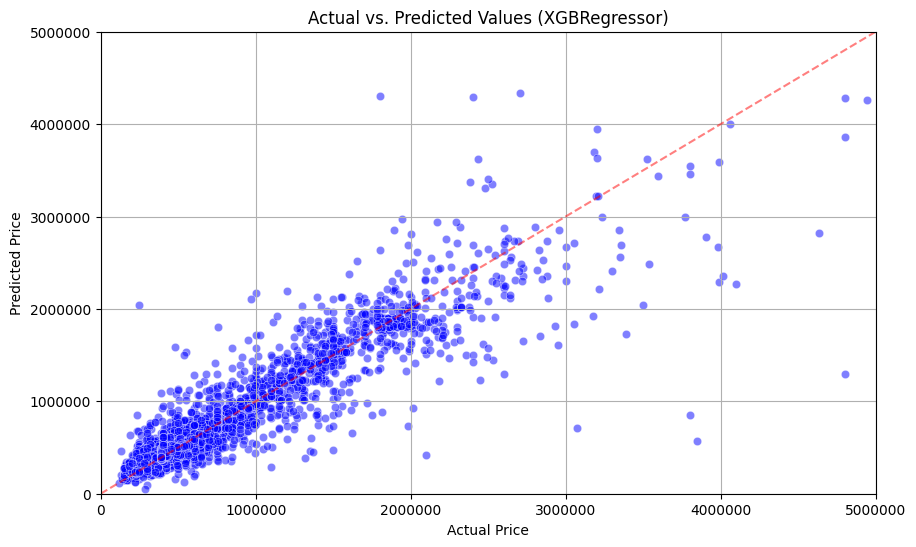

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to plot scatter plot of actual vs predicted values
def plot_scatter(actual, predicted, model_name):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=actual, y=predicted, color='blue', alpha=0.5)
    plt.title(f'Actual vs. Predicted Values ({model_name})')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.xlim(0, 5000000)  # Set x-axis limits from 0 to 15,000,000
    plt.ylim(0, 5000000)  # Set y-axis limits from 0 to 15,000,000
    plt.gca().ticklabel_format(style='plain')  # Set tick labels without scientific notation
    plt.plot([0, 5000000], [0, 5000000], color='red', linestyle='--', alpha=0.5)  # Add diagonal line for perfect predictions
    plt.grid(True)
    plt.show()

# Plot scatter plot for each model
models = [xgb_regressor]  # Add other models if you have trained them
model_names = ['XGBRegressor']  # Adjust model names accordingly

for model, model_name in zip(models, model_names):
    predictions = model.predict(X_test)
    plot_scatter(y_test, predictions, model_name)

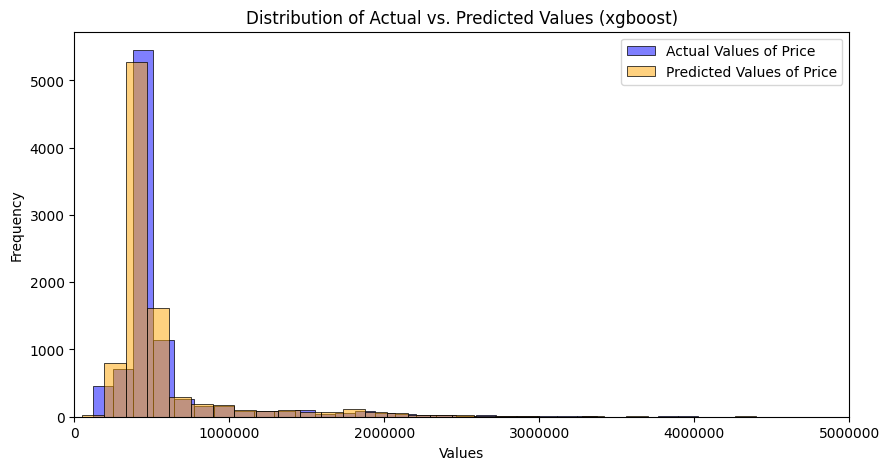

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to plot distributions of actual and predicted values
def plot_distributions(actual, predicted, model_name):
    plt.figure(figsize=(10, 5))
    sns.histplot(actual, bins=100, color='blue', alpha=0.5, label='Actual Values of Price')
    sns.histplot(predicted, bins=100, color='orange', alpha=0.5, label='Predicted Values of Price')
    plt.legend()
    plt.title(f'Distribution of Actual vs. Predicted Values ({model_name})')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.ylim(0, )  # Set y-axis limits from 0 to 1,000,000
    plt.xlim(0, 5000000)  # Set x-axis limits from 0 to 1,500,000
    plt.gca().ticklabel_format(style='plain')  # Set tick labels without scientific notation
    plt.show()

# Plot distributions for each model
models = [xgb_regressor]  # Add other models if you have trained them
model_names = ['xgboost']  # Adjust model names accordingly

for model, model_name in zip(models, model_names):
    predictions = model.predict(X_test)
    plot_distributions(y_test, predictions, model_name)




In [ ]:
import matplotlib as mpl

In [ ]:
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

In [ ]:
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
mpl.rc('font', family='TH Sarabun New', size= 7)

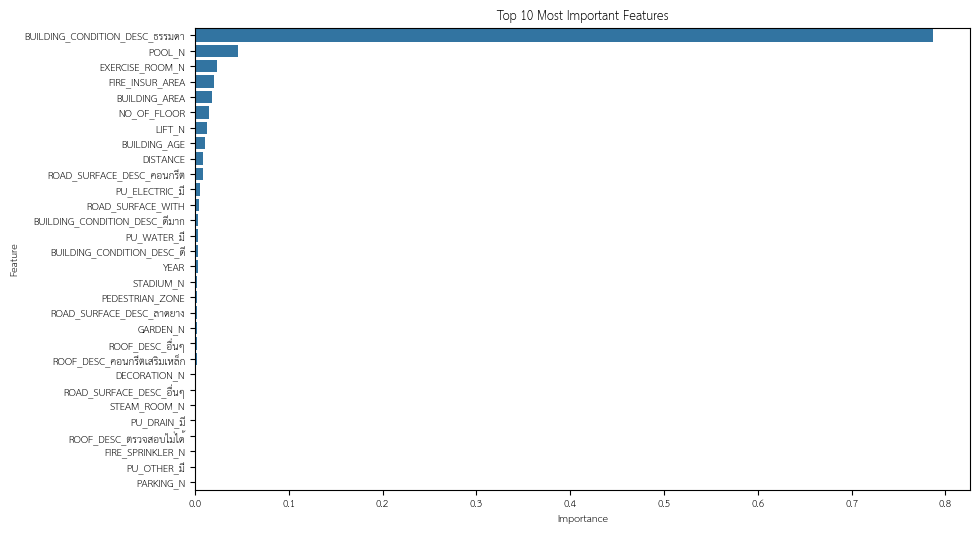

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'xgb' is your XGBoost model
feature_importances = xgb_regressor.feature_importances_

# Get the names of the features
feature_names = X_test.columns  # Assuming X_test is a pandas DataFrame

# Create a DataFrame with feature names and their corresponding importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(30))  # Plotting top 10 features
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.show()


In [ ]:
# Importing required libraries
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Assuming df_final is your DataFrame with features and target variable CLP
# Splitting the data into features (X) and target variable (y)
X = df_final.drop('CLP', axis=1)  # Features
y = df_final['CLP']  # Target variable

# Splitting dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate the KNN Regressor
knn_regressor = KNeighborsRegressor()

# Fit the model to the training data
knn_regressor.fit(X_train, y_train)

# Predict on the test data
y_pred = knn_regressor.predict(X_test)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)


Mean Absolute Percentage Error (MAPE): 12.76658556679805


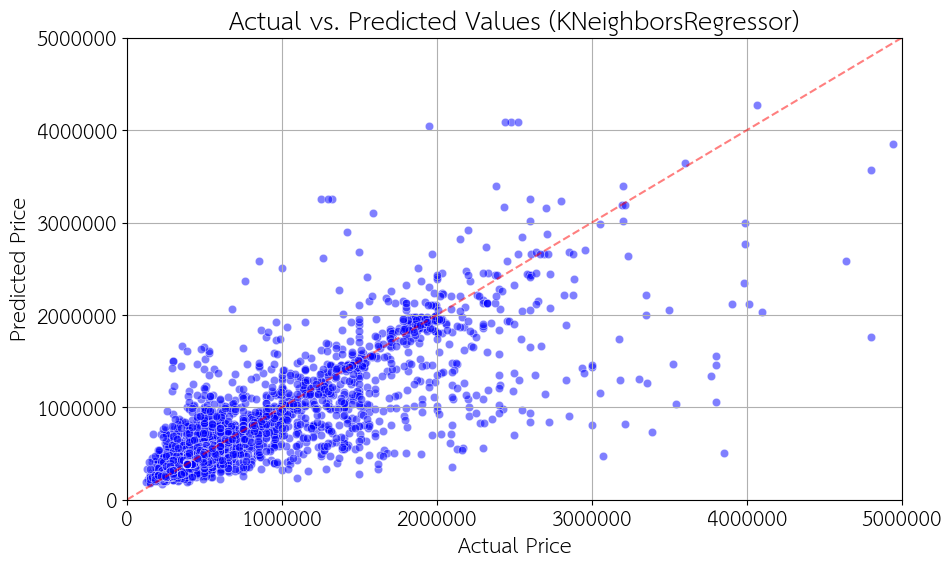

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to plot scatter plot of actual vs predicted values
def plot_scatter(actual, predicted, model_name):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=actual, y=predicted, color='blue', alpha=0.5)
    plt.title(f'Actual vs. Predicted Values ({model_name})')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.xlim(0, 5000000)  # Set x-axis limits from 0 to 15,000,000
    plt.ylim(0, 5000000)  # Set y-axis limits from 0 to 15,000,000
    plt.gca().ticklabel_format(style='plain')  # Set tick labels without scientific notation
    plt.plot([0, 5000000], [0, 5000000], color='red', linestyle='--', alpha=0.5)  # Add diagonal line for perfect predictions
    plt.grid(True)
    plt.show()

# Plot scatter plot for each model
models = [knn_regressor]  # Add other models if you have trained them
model_names = ['KNeighborsRegressor']  # Adjust model names accordingly

for model, model_name in zip(models, model_names):
    predictions = model.predict(X_test)
    plot_scatter(y_test, predictions, model_name)

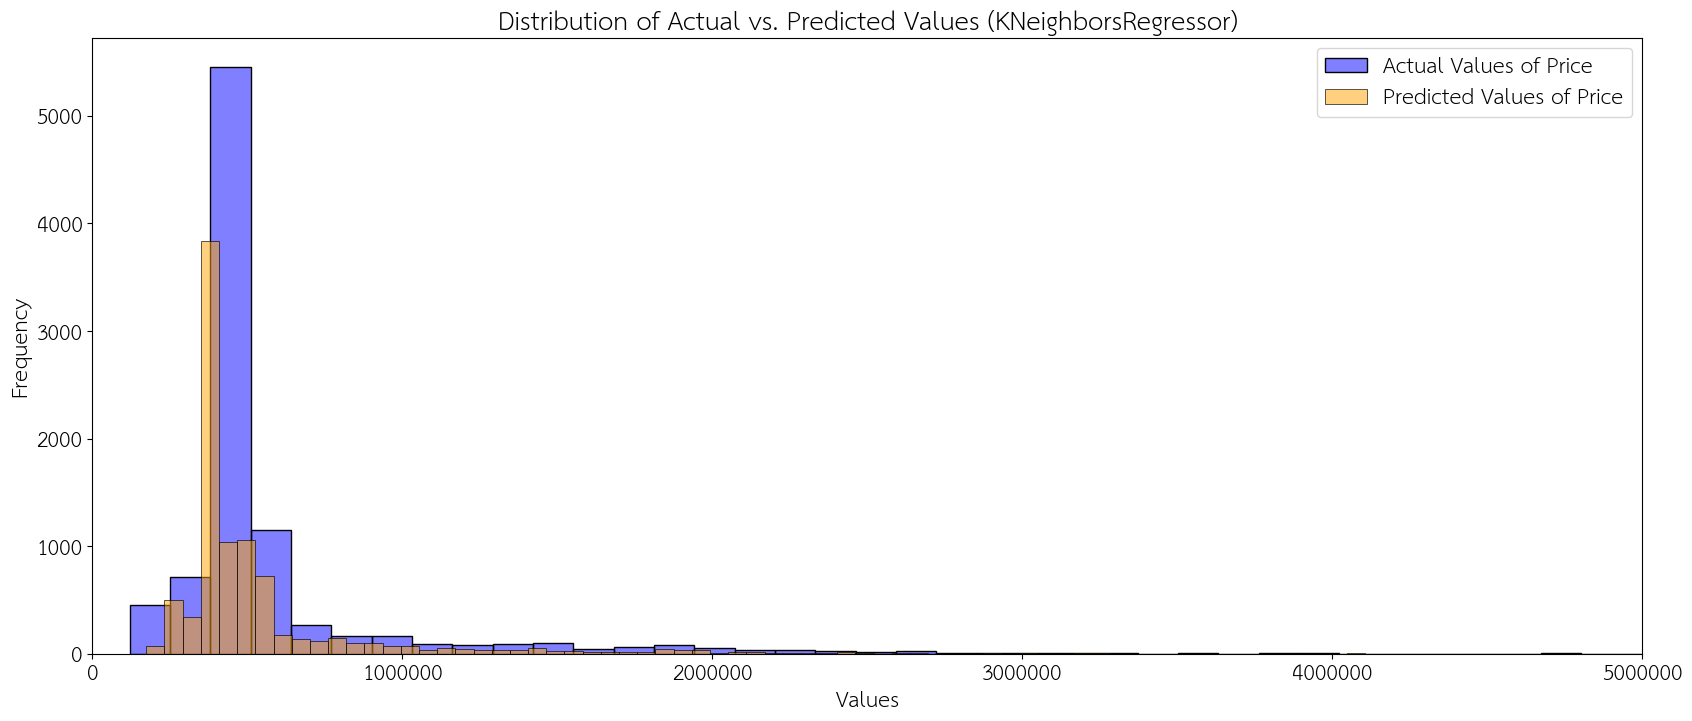

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to plot distributions of actual and predicted values
def plot_distributions(actual, predicted, model_name):
    plt.figure(figsize=(20, 8))
    sns.histplot(actual, bins=100, color='blue', alpha=0.5, label='Actual Values of Price')
    sns.histplot(predicted, bins=100, color='orange', alpha=0.5, label='Predicted Values of Price')
    plt.legend()
    plt.title(f'Distribution of Actual vs. Predicted Values ({model_name})')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.ylim(0, )  # Set y-axis limits from 0 to 1,000,000
    plt.xlim(0, 5000000)  # Set x-axis limits from 0 to 1,500,000
    plt.gca().ticklabel_format(style='plain')  # Set tick labels without scientific notation
    plt.show()

# Plot distributions for each model
models = [knn_regressor]  # Add other models if you have trained them
model_names = ['KNeighborsRegressor']  # Adjust model names accordingly

for model, model_name in zip(models, model_names):
    predictions = model.predict(X_test)
    plot_distributions(y_test, predictions, model_name)




In [ ]:
pip install seaborn matplotlib

In [ ]:
# Importing required libraries
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# Assuming df_final is your DataFrame with features and target variable CLP
# Splitting the data into features (X) and target variable (y)
X = df_final.drop('CLP', axis=1)  # Features
y = df_final['CLP']  # Target variable

# Splitting dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate the Extra Trees Regressor
extra_trees = ExtraTreesRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
extra_trees.fit(X_train, y_train)

# Predict on the test data
y_pred = extra_trees.predict(X_test)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')


Mean Absolute Percentage Error (MAPE): 9.04%


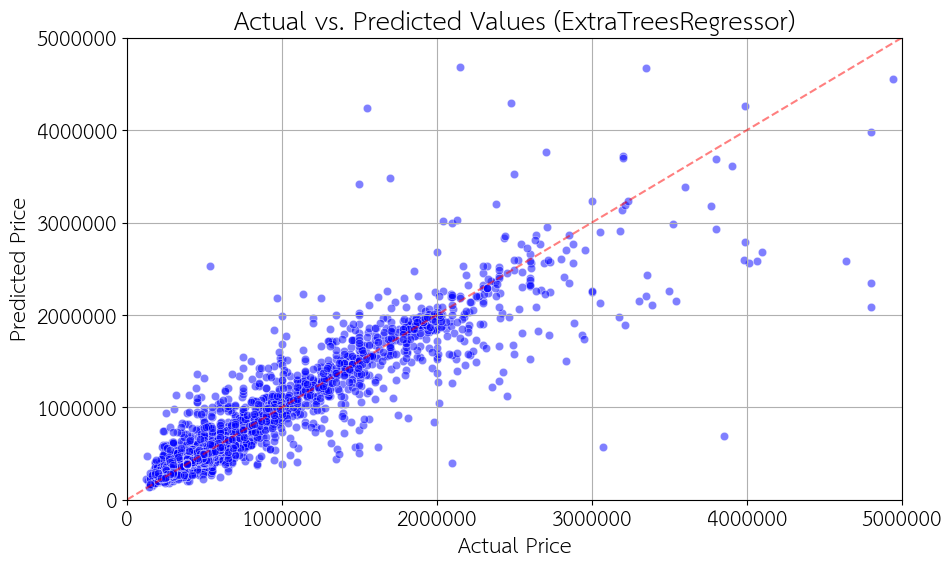

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to plot scatter plot of actual vs predicted values
def plot_scatter(actual, predicted, model_name):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=actual, y=predicted, color='blue', alpha=0.5)
    plt.title(f'Actual vs. Predicted Values ({model_name})')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.xlim(0, 5000000)  # Set x-axis limits from 0 to 15,000,000
    plt.ylim(0, 5000000)  # Set y-axis limits from 0 to 15,000,000
    plt.gca().ticklabel_format(style='plain')  # Set tick labels without scientific notation
    plt.plot([0, 5000000], [0, 5000000], color='red', linestyle='--', alpha=0.5)  # Add diagonal line for perfect predictions
    plt.grid(True)
    plt.show()

# Plot scatter plot for each model
models = [extra_trees]  # Add other models if you have trained them
model_names = ['ExtraTreesRegressor']  # Adjust model names accordingly

for model, model_name in zip(models, model_names):
    predictions = model.predict(X_test)
    plot_scatter(y_test, predictions, model_name)

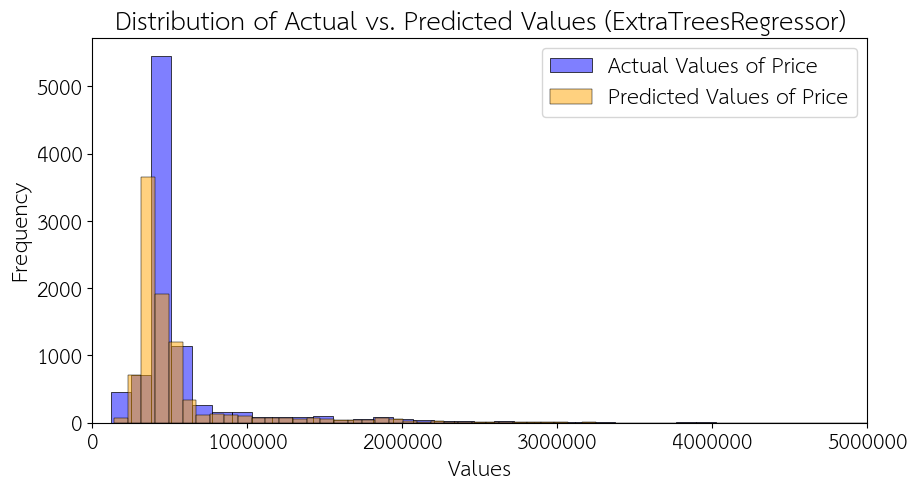

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to plot distributions of actual and predicted values
def plot_distributions(actual, predicted, model_name):
    plt.figure(figsize=(10, 5))
    sns.histplot(actual, bins=100, color='blue', alpha=0.5, label='Actual Values of Price')
    sns.histplot(predicted, bins=100, color='orange', alpha=0.5, label='Predicted Values of Price')
    plt.legend()
    plt.title(f'Distribution of Actual vs. Predicted Values ({model_name})')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.ylim(0, )  # Set y-axis limits from 0 to 1,000,000
    plt.xlim(0, 5000000)  # Set x-axis limits from 0 to 1,500,000
    plt.gca().ticklabel_format(style='plain')  # Set tick labels without scientific notation
    plt.show()

# Plot distributions for each model
models = [extra_trees]  # Add other models if you have trained them
model_names = ['ExtraTreesRegressor']  # Adjust model names accordingly

for model, model_name in zip(models, model_names):
    predictions = model.predict(X_test)
    plot_distributions(y_test, predictions, model_name)

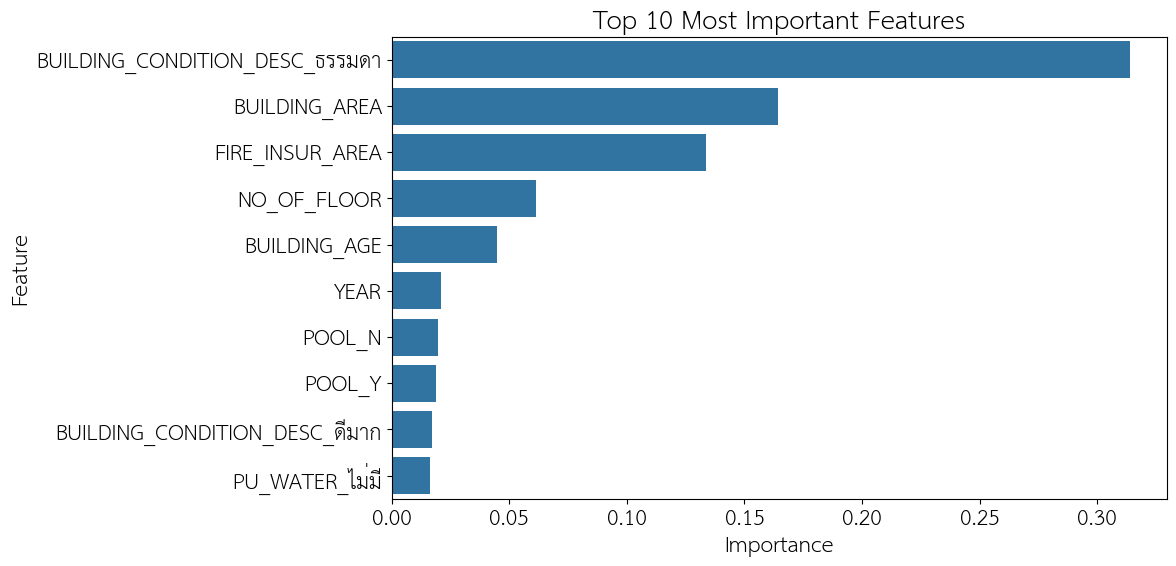

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature importances
feature_importances = extra_trees.feature_importances_

# Get the names of the features
feature_names = X_train.columns  # Assuming X_train is a pandas DataFrame

# Create a DataFrame with feature names and their corresponding importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))  # Plotting top 10 features
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.show()
